In [1]:
import sys
sys.path.append('..')
import torch
from torchvision import datasets, transforms
from models import VAE, loss_function
from problems import get_problem
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

p = get_problem('sum_25', 'int', train_ratio=1.)

def get_digit(digit, train):
    test_digits = []
    for data, label in datasets.MNIST('../data', train=train, download=True, transform=transforms.ToTensor()):
        if digit == -1 or label.item() == digit:
            test_digits.append((data, label))
    return test_digits

In [43]:
# Load all VAES
vaes = {}
for i in xrange(10):
    vae = VAE()
    state_dict = torch.load('digit_{}_epoch_80.pth'.format(i))
    vae.load_state_dict(state_dict)
    vaes[i] = vae
    
# Build visual models (from VAEs)
def create_visual_model(digit_idx, vaes):
    def visual_model(digit_image):
        x = digit_image.view((1, 1, 28, 28))
        reconstruction, mu, logvar = vaes[digit_idx](x)
        nll = loss_function(reconstruction, x, mu, logvar)
        return nll
    return visual_model
visual_models = [create_visual_model(i, vaes) for i in xrange(10)]

In [33]:
# Load all MNISTs
batch_size = 1

# Load all MNIST digits
test_digits = {}
test_loaders = {}
for i in xrange(10):
    print 'Loading digit', i
    test_digit = get_digit(i, train=False)
    test_digits[i] = test_digit
    
    test_loader = torch.utils.data.DataLoader(test_digit, batch_size=batch_size, shuffle=True)
    test_loaders[i] = test_loader
    
# Build visual samplers (from test set)
def create_visual_sampler(i, test_loaders):
    def visual_sampler():
        return iter(test_loaders[int(i)]).next()[0][0,0]
    return visual_sampler
visual_samplers = [create_visual_sampler(i, test_loaders) for i in xrange(10)]

print visual_samplers[8]().size()

Loading digit 0
Loading digit 1
Loading digit 2
Loading digit 3
Loading digit 4
Loading digit 5
Loading digit 6
Loading digit 7
Loading digit 8
Loading digit 9
torch.Size([28, 28])


# Symbolic Combination to Image Combination

Size torch.Size([5, 28, 28])


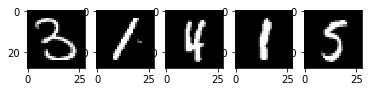

In [48]:
# Combination to Visual
def to_visual(combination, visual_samplers):
    '''
    Sample a visual representation for a symbolic combination
    
    Parameters
    ----------
    combination: np.ndarray (part~5) combination to encode
    visual_samplers: dict of 10 callable objects which return a random corresponding (28, 28) digit
    
    Returns
    -------
    visual_combination: torch.Tensor (part~5, height~28, width~28)
    '''
    x = []
    for c in combination:
        sample = visual_samplers[c]()
        x.append(sample[None, :, :])
    visual_combination = torch.cat(x)
    return visual_combination

# Test: combination to visual_combination    
visual_combination = to_visual([3, 1, 4, 1, 5], visual_samplers)

print 'Size', visual_combination.size()
for i in xrange(5):
    plt.subplot(1,5,i+1)
    plt.imshow(visual_combination[i].numpy(), cmap='gray')

# Likelihood of Sum-25 with Joint generator

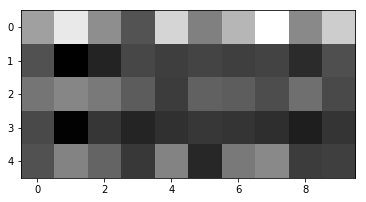

In [49]:
# Precompute conditional visual likelihoods
def get_per_digit_likelihood(visual_combination, visual_models):  # return -log likelihoods
    '''
    Compute NLL given by each visual model (e.g. VAE) to each visual digit.
    
    Parameters
    ----------
    visual_combination: torch.Tensor (part~5, height~28, width~28)
    visual_models: dictionary of objects which can be called on x and return a nll

    Return
    ------
    visual_likelihoods: np.ndarray (part~5, digit~10)
    '''
    visual_likelihoods = np.zeros((5, 10))
    for part in xrange(5):
        for model_idx in xrange(10):
            digit_image = visual_combination[part]
            l = visual_models[model_idx](digit_image)
            visual_likelihoods[part, model_idx] = l  # since it's -log likelihood
    return visual_likelihoods

# Test: get conditional nll for each digit of visual combination
visual_likelihoods = get_per_digit_likelihood(visual_combination, visual_models)
plt.imshow(visual_likelihoods, 'gray')


In [52]:
# Sum over all combinations in symbolic model
conditional_likelihoods = []

def log_sum_exp(v):
    v = np.asarray(v)
    v_max = v.max()
    return v_max + np.log(np.sum(np.exp(v - v_max)))


def get_one_sample_likelihood(visual_likelihoods, model_combinations):
    '''
    Return likelihood given by a joint model for one visual sample.
    
    Parameters
    ----------
    visual_likelihoods: np.ndarray (part~5, digit~10) of per_digit likelihoods
    model_combinations: np.ndarray (combination~1000, part~5) 
        symbolic model is uniform distribution on those combinations.
    
    Returns
    -------
    likelihood: nll for that given sample: -log { 1/|C| sum_{z\in C} p(z) \prod_i p(x_i | z_i) }
    conditional_likelihoods: -\sum_i \log p(x_i | z_i)
    closest_combination: return combination z in model_combinations with highest likelihood
    '''
    conditional_likelihoods = []
    for combination in model_combinations:  # iterate over possible z
        tmp = 0.
        for part, c in enumerate(combination):
            p_xPart_given_zPart = visual_likelihoods[part, c]
            tmp += p_xPart_given_zPart
        conditional_likelihoods.append(tmp)
    likelihood = np.log(len(p.train_positive)) - log_sum_exp(-np.asarray(conditional_likelihoods))  # get NLL
    # for debugging return closest combination
    best_x_z = np.argmin(conditional_likelihoods)  # smallest log likelihood
    closest_combination = p.train_positive[best_x_z]
    return likelihood, conditional_likelihoods, closest_combination
    
    
# Test: get liklelihood for sample giving visual_likelihood
likelihood, conditional_likelihoods, closest_combination = get_one_sample_likelihood(
    visual_likelihoods, p.train_positive)

# Note that the largest conditional likelihood should correspond classifying the combination
# if combination verifies constraint
print 'Closest combination match', closest_combination
print 'Likelihood', likelihood

Closest combination match [3 1 4 8 9]
Likelihood 481.3769402361114


# Repeat this over all training set combinations X model combinations
[Main Function]

In [55]:
def get_likelihood(target_combinations, model_combinations,
                    visual_samplers, visual_models, max_iterations=200):
    '''
    Return estimated likelihood for 
    '''
    all_likelihoods = []
    for i, combination in enumerate(p.train_positive):  # true distribution to reach
        
        if i >= max_iterations:
            break
        
        # Transform symbolic combination to visual
        visual_combination = to_visual(combination, visual_samplers)
        
        # Compute likelihood of each part(digit) with each visual conditional model 
        visual_likelihoods = get_per_digit_likelihood(visual_combination, visual_models)  
        
        # Compute likelihood of that visual sample
        likelihood, conditional_likelihoods, closest_combination = get_one_sample_likelihood(
            visual_likelihoods, model_combinations)  # model distribution

        # Logging
        all_likelihoods.append(likelihood)
        average_nll = np.mean(all_likelihoods)
        std = np.std(all_likelihoods) / np.sqrt(len(all_likelihoods))
        if i % 50 == 0:
            print 'Combination #', i
            print 'Combination', combination
            print 'closest', closest_combination
            print 'Likelihood', likelihood
            print 'Average NLL: {:.1f} +/- {:.1f}'.format(average_nll, std) 
            
    return average_nll, std

target_combinations = p.train_positive
model_combinations = p.train_positive
average_nll, std = get_likelihood(target_combinations, model_combinations,
                    visual_samplers, visual_models, max_iterations=200)

print 'NLL in [{:.1f}; {:.1f}]'.format(average_nll-std, average_nll+std)

Combination # 0
Combination [4 9 2 6 4]
closest [4 9 2 6 4]
Likelihood 515.6616694614848
Average NLL: 515.7 +/- 0.0
Combination # 50
Combination [6 9 1 1 8]
closest [6 9 1 1 8]
Likelihood 386.8954646275007
Average NLL: 497.0 +/- 8.2
Combination # 100
Combination [0 3 7 8 7]
closest [0 3 7 8 7]
Likelihood 468.18712875103586
Average NLL: 496.2 +/- 5.7
Combination # 150
Combination [8 7 5 3 2]
closest [8 7 5 3 2]
Likelihood 515.4495265171491
Average NLL: 490.6 +/- 4.7
NLL in [483.1; 491.2]
